# Forecasting tax avoidance rates by international listed companies

## Problem description

**Tax avoidance is not a crime!** Companies that carry out this act are on the verge of law. By definition: tax avoidance consists in carrying out economic activities in such a way that they are understood in a different way from tax regulations, in order to reduce the tax burden. International tax avoidance arose as a result of globalization and liberalization of economic systems of countries, weakening trade barriers and development of new technologies. Tax avoidance is achieved through aggressive **tax optimization** (e.g. tax havens, double taxation agreements, etc.). 

In this study, we will check whether we can **forecast for one year ahead the level of tax avoidance by a group of companies** listed on stock exchanges using shallow Machine Learning models. As the econometric research shows, this problem is non-trivial, and the most important determinants result from the financial statements per se. The question arises whether any additional data sources can be used to forecast this problem. Forecasting such a phenomenon may be particularly important for the tax authorities and legislators. It helps to create rules that would fight against tax avoidance!

There are many ways in the literature to measure tax avoidance. All of them have their advantages and disadvantages. However, the most popular metric appears to be Effective Tax Rate (ETR) = $\dfrac{\textrm{total tax expenses}}{\textrm{pre-tax income}} $. Due to this formula, ETR has values in the range [0,1]. This measure applies directly to each jurisdiction and it is based on annual data published in the financial statements and this involves an annual change in the effective tax rate, or failure to determine it , in the case of negative income tax resulting from current tax overruns of deferred tax assets. ETR will be used as the target/endogenous variable in this study. Therefore, the following evaluation metrics for the given problem were selected: Mean Absolute Error (MAE), Root Mean Square error (RMSE). The choice was not accidental: MAE allows for relatively easy interpretation, while RMSE punishes model for large individual errors, which in the case of ETR forecasting may be crucial. For this case, absolute measures seem to be a more correct approach than relative ones. Nevertheless, the most important metric will be RMSE.

This problem is a classic panel problem (many companies and many years).

## Dataset description

The database used in the study was created for the purposes of the paper "Determinants of multinational tax avoidance" (Agnieszka Teterycz, PhD. Anna Białek) on the basis of data retrieved from the Bloomberg database, OECD and PWC reports. Information on the introduction of regulations concerning foreign controlled companies (CFCs) in the analysed countries has been selected from OECD reports. From the reports prepared by PWC, data specifying the number of double taxation agreements signed in the analysed countries were selected. The dataset gather companies included in WIG, DAX, UK100, CAC40 and ATX indices listed on stock exchanges in Poland, Germany, Great Britain, France and Austria in 2005-2017. All companies from the financial (including banks) and insurance sectors were excluded from the analysis, as well as those with missing data in the explanatory variables. In addition, the observations that took a negative value for the financial result before tax and income tax were removed in order to avoid situations where a negative value of ETR would be difficult to interpret. The above exclusions and removal of outlier observations reduced the sample for panel data from 7 800 to 4 719 observations. Panel data are balanced (13 years x 363 companies). Inputation process was applied - using medians and means at the company level. Authors also used fill forward interpolation at the beginning of the time series.

#### Columns description 

* index - technical index
* ticker - company ticker from stock exchange
* Nazwa2 - full name of a company
* sektor - business sector of a company
* rok - year
* gielda - the stock exchange from which the company originates {1: Warsaw, 2: London, 3: Frankfurt, 4: Paris, 5: Vienna}
* ta - total assets of a company 
* txt - total tax expenses of a company 
* pi - pre-tax income of a company 
* str - statutory tax rate of a company 
* xrd - research and development expenditure of a company 
* ni - net income of a company 
* ppent - property plant and equipment net of a company  
* intant - total intangible assets of a company 
* dlc - long term debt of a company 
* dltt - short term debt of a company 
* capex - capital expenditures of a company 
* revenue - revenue of a company 
* cce - cash and cash equivalents of a company 
* adv - advertising expenses of a company  
* etr - effective tax rate of a company
* diff - statutory tax rate - effective tax rate
* roa - return of assets of a company
* lev - leverage of a company
* intan - intangible assets/total assets
* rd - research and development expenditure/total assets
* ppe - property plant and equipment/total assets
* sale - log(revenue of a company/total assets)
* cash_holdings - cash and cash equivalents of a company/total assets
* adv_expenditures - advertising expenses/total assets
* capex2 - capex/property plant and equipment
* cfc - control foreign companies by a company
* dta - double taxation agreements of a company 
* capex2_scaled - scaled capex2

the rest of the columns are technical and redundant, so they will be deleted!

## Dependencies loading

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
pd.set_option('display.max_columns', 500)

## Data preparation

### Data loading

In [103]:
df = pd.read_stata("../data/tax_avoidance.dta")

In [104]:
df.sample(10)

,index,Ticker,Nazwa2,sektor,rok,gielda,ta,txt,pi,str,xrd,ni,ppent,intant,dlc,dltt,capex,revenue,cce,adv,etr,diff,roa,lev,intan,rd,ppe,sale,cash_holdings,adv_expenditure,capex2,cfc,dta,capex2_scaled,firm_id,firma_id,rok2005,rok2006,rok2007,rok2008,rok2009,rok2010,rok2011,rok2012,rok2013,rok2014,rok2015,rok2016,rok2017,industry,industry1,capex1,roa1,country1,country2,country3,country4,country5,industry11,industry12,industry13,industry14,industry15,industry16,industry17,industry18,industry19,industry20,diff1,diff2,diff3,_est_random,_est_fixed
1913,946,IMS PW Equity,IMS SA,communication,2007,1,23.027668,0.734667,2.829333,0.1900,0.0,2.093000,7.413111,3.171889,2.790111,2.822556,1.880333,26.938889,3.724222,0.0,0.259661,-0.069661,0.090891,0.243736,0.137743,0.000000,0.321922,0.774657,0.161728,0.0,0.253650,0,0,0.000235,IMS SA,IMS SA,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,communication,communication,1.057906,0.090891,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.069661,-0.069661,-0.069661,1,1
3157,1899,PPS PW Equity,Pepees SA,consumer staples,2016,1,272.165985,4.777000,22.674999,0.1900,0.0,17.600000,119.315002,6.905000,27.047001,77.981003,12.555000,185.675003,24.176001,0.0,0.210673,-0.020673,0.064666,0.385897,0.025371,0.000000,0.438391,0.520110,0.088828,0.0,0.105226,1,0,0.000098,Pepees SA,Pepees SA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,consumer staples,consumer staples,2.606755,0.064666,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.020673,-0.020673,-0.020673,1,1
831,4186,CA FP Equity,Carrefour SA,consumer staples,2017,4,870128.000000,1083.000000,7686.000000,0.3443,6209.0,1380.000000,0.000000,20452.000000,8099.000000,6651.000000,393.000000,132592.000000,23898.000000,0.0,0.140906,0.203394,0.001586,0.016952,0.023505,0.007136,0.000000,0.141831,0.027465,0.0,0.000000,1,1,0.000000,Carrefour SA,Carrefour SA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,consumer staples,consumer staples,5.976351,0.001586,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.203394,0.203394,0.203394,1,1
973,2718,CON GY Equity,Continental AG,consumer discretionary,2016,2,36174.898438,1096.800049,3978.800049,0.2972,2811.5,2802.500000,10538.099609,8371.400391,2889.000000,2126.000000,2592.500000,40549.500000,2107.000000,0.0,0.275661,0.021539,0.077471,0.138632,0.231415,0.077720,0.291310,0.751854,0.058245,0.0,0.246012,1,0,0.000228,Continental AG,Continental AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,consumer discretionary,consumer discretionary,7.860764,0.077471,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021539,0.021539,0.021539,1,1
4586,2485,WOJ PW Equity,Wojas SA,consumer discretionary,2015,1,165.653000,0.360000,4.024000,0.1900,0.0,3.664000,44.257000,0.296000,16.535999,36.050999,6.933000,213.207001,1.368000,0.0,0.089463,0.100537,0.022119,0.317453,0.001787,0.000000,0.267167,0.827272,0.008258,0.0,0.156653,1,0,0.000145,Wojas SA,Wojas SA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,consumer discretionary,consumer discretionary,2.071031,0.022119,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100537,0.100537,0.100537,1,1
167,118,ALL PW Equity,Ailleron SA,technology,2016,1,128.789001,0.451000,8.072000,0.1900,0.0,7.621000,15.403000,45.395000,12.292000,4.401000,1.323000,89.044998,14.990000,0.0,0.055872,0.134128,0.059174,0.129615,0.352476,0.000000,0.119599,0.525558,0.116392,0.0,0.085892,1,0,0.000080,Ailleron SA,Ailleron SA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,technology,technology,0.842859,0.059174,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.134128,0.134128,0.134128,1,1
3843,3267,SHL GY Equity,Siemens Healthineers AG,health care,2013,2,20064.000000,591.333313,1946.000000,0.3100,0.0,1384.666626,1403.333374,9758.333008,3587.000000,5641.000000,206.333328,13426.333008,154.333328,0.0,0.303871,0.006129,0.069012,0.459928,0.486360,0.000000,0.069943,0.512330,0.007692,0.0,0.147031,1,0,0.000136,Siemens Healthineers AG,Siemens Heal

### Dataset adjustment

##### Removing redundant variables

In [105]:
df.columns

Index(['index', 'Ticker', 'Nazwa2', 'sektor', 'rok', 'gielda', 'ta', 'txt',
       'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex',
       'revenue', 'cce', 'adv', 'etr', 'diff', 'roa', 'lev', 'intan', 'rd',
       'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'cfc',
       'dta', 'capex2_scaled', 'firm_id', 'firma_id', 'rok2005', 'rok2006',
       'rok2007', 'rok2008', 'rok2009', 'rok2010', 'rok2011', 'rok2012',
       'rok2013', 'rok2014', 'rok2015', 'rok2016', 'rok2017', 'industry',
       'industry1', 'capex1', 'roa1', 'country1', 'country2', 'country3',
       'country4', 'country5', 'industry11', 'industry12', 'industry13',
       'industry14', 'industry15', 'industry16', 'industry17', 'industry18',
       'industry19', 'industry20', 'diff1', 'diff2', 'diff3', '_est_random',
       '_est_fixed'],
      dtype='object')

In [106]:
df.drop(columns=['index', 'firm_id', 'firma_id', 'rok2005', 'rok2006',
       'rok2007', 'rok2008', 'rok2009', 'rok2010', 'rok2011', 'rok2012',
       'rok2013', 'rok2014', 'rok2015', 'rok2016', 'rok2017', 'industry',
       'industry1', 'capex1', 'roa1', 'country1', 'country2', 'country3',
       'country4', 'country5', 'industry11', 'industry12', 'industry13',
       'industry14', 'industry15', 'industry16', 'industry17', 'industry18',
       'industry19', 'industry20', 'diff1', 'diff2', 'diff3', '_est_random',
       '_est_fixed'], inplace = True)

df.shape

(4719, 33)

##### Checking if every variable has proper type

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4719 entries, 0 to 4718
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ticker           4719 non-null   object 
 1   Nazwa2           4719 non-null   object 
 2   sektor           4719 non-null   object 
 3   rok              4719 non-null   int16  
 4   gielda           4719 non-null   int8   
 5   ta               4719 non-null   float64
 6   txt              4719 non-null   float64
 7   pi               4719 non-null   float64
 8   str              4719 non-null   float64
 9   xrd              4719 non-null   float64
 10  ni               4719 non-null   float64
 11  ppent            4719 non-null   float64
 12  intant           4719 non-null   float64
 13  dlc              4719 non-null   float64
 14  dltt             4719 non-null   float64
 15  capex            4719 non-null   float64
 16  revenue          4719 non-null   float64
 17  cce           

#### Endogenous variable shifting

In [108]:
df.sort_values(by = ["Ticker","rok"],inplace = True)
df["etr"] = df["etr"].shift(-1)
df = df[df.rok != 2017]

df.shape

(4356, 33)

### External data adding

It was assumed in accordance with the effective market hypothesis that all information about specific companies is included in their book values at the end of the year, i.e. analyzing additional individual stock market data would rather not have the desired effect. In addition, company names (tickers) are not perfect and in some cases it is very difficult to find the right company on websites such as: stooq.pl. Therefore, the bulk approach is not optimal, and manual download would take too much time. Therefore, it was decided to choose variables that will testify to the condition of selected stock exchanges and the entire economy in each country.

**We checked that all added data is available no later than 3 months after the end of a given year. There is no date leakag here !!! The company's financial year should be taken into account, not the calendar year!**

#### First source: World Bank, V-Dem index, Polity index, BR index
We assume that variables like: democracy indices (proxy for investment moods), GDP growth, GDP per capita and Inflation (proxy for business cycle ) might be significant in case of tax avoidance predictions. Data were gathered for mentioned above 5 countries (2005-2017). This data chunk is a part of our own dataset, which collects determinants of democracy. We don't want to share it right now, so we slice it.

In [114]:
df_extra0 = pd.read_csv("../data/external_dataset.csv",sep=';')

In [115]:
df_extra0.head()

,country_name,year,y_v2x_polyarchy,y_e_p_polity,y_BR_Democracy,WB_GDPgrowth,WB_GDPpc,WB_Inflation
0,Austria,2005,0.855,10,1,2.244065,38403.13388,2.299139
1,Austria,2006,0.863,10,1,3.454042,40635.28182,1.441547
2,Austria,2007,0.885,10,1,3.727415,46855.77175,2.168556
3,Austria,2008,0.884,10,1,1.460424,51708.76575,3.215950
4,Austria,2009,0.894,10,1,-3.764578,47963.17940,0.506308


In [116]:
df_extra0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country_name     65 non-null     object 
 1   year             65 non-null     int64  
 2   y_v2x_polyarchy  65 non-null     float64
 3   y_e_p_polity     65 non-null     int64  
 4   y_BR_Democracy   65 non-null     int64  
 5   WB_GDPgrowth     65 non-null     float64
 6   WB_GDPpc         65 non-null     float64
 7   WB_Inflation     65 non-null     float64
dtypes: float64(4), int64(3), object(1)
memory usage: 4.2+ KB


In [117]:
df_extra0.country_name.unique()

array(['Austria', 'France', 'Germany', 'Poland', 'United Kingdom'],
      dtype=object)

In [118]:
df_extra0.country_name = df_extra0.country_name.map({"Poland":1,"United Kingdom":2,"Germany":3,"France":4,"Austria":5})

In [119]:
df_extra0.country_name.unique()

array([5, 4, 3, 1, 2], dtype=int64)

In [120]:
df.shape

(4356, 33)

In [121]:
df = pd.merge(df, df_extra0, left_on = ["gielda","rok"], right_on= ["country_name","year"], how = "left")
df.drop(columns = ["country_name","year"],inplace=True)

In [122]:
df.shape

(4356, 39)

#### Second source: main stock market indexes for Poland (WIG), Germany (DAX), Great Britain (FTSE), France (CAC) and Austria (ATX)
We assume that variables like yearly rates of returns might be additional proxy for market condition in each country.

In [123]:
cac = pd.read_csv("../data/external_dataset1/^cac_y.csv")
dax = pd.read_csv("../data/external_dataset1/^dax_y.csv")
a5c = pd.read_csv("../data/external_dataset1/a5_c_y.csv")
wig = pd.read_csv("../data/external_dataset1/wig_y.csv")
xf = pd.read_csv("../data/external_dataset1/x_f_y.csv")

In [124]:
cac["Date"] = pd.to_datetime(cac.Data)
cac["year"] = cac.Date.dt.year
cac["rr"] = (cac.Zamkniecie - cac.Otwarcie)/cac.Otwarcie
cac["country"] = 4

dax["Date"] = pd.to_datetime(dax.Data)
dax["year"] = dax.Date.dt.year
dax["rr"] = (dax.Zamkniecie - dax.Otwarcie)/dax.Otwarcie
dax["country"] = 3

a5c["Date"] = pd.to_datetime(a5c.Data)
a5c["year"] = a5c.Date.dt.year
a5c["rr"] = (a5c.Zamkniecie - a5c.Otwarcie)/a5c.Otwarcie
a5c["country"] = 5

wig["Date"] = pd.to_datetime(wig.Data)
wig["year"] = wig.Date.dt.year
wig["rr"] = (wig.Zamkniecie - wig.Otwarcie)/wig.Otwarcie
wig["country"] = 1

xf["Date"] = pd.to_datetime(xf.Data)
xf["year"] = xf.Date.dt.year
xf["rr"] = (xf.Zamkniecie - xf.Otwarcie)/xf.Otwarcie
xf["country"] = 2

In [125]:
tmp = pd.concat([cac,dax,a5c,wig,xf])
tmp = tmp[["year","rr","country"]]
tmp.rename(columns={"rr":"rr_per_country"},inplace=True)

In [126]:
df = pd.merge(df, tmp, left_on = ["rok","gielda"], right_on= ["year","country"], how = "left")
df.drop(columns = ["year","country"],inplace=True)

In [127]:
df.shape

(4356, 40)

#### Third source: S&P indexes for sectors
We believe that S&P indexes for sectors might be good proxies for each sector condition during each year!

In [128]:
df.sektor.value_counts()

consumer discretionary    924
industrials               816
materials                 672
technology                444
consumer staples          324
real estate               312
communication             300
health care               228
utilities                 204
energy                    132
Name: sektor, dtype: int64

In [129]:
def data_adjuster(tmp, sec):
    foo = tmp["May 20"].str.split(" ", n = 1, expand = True)
    tmp["0"] = foo[0]
    tmp["1"] = foo[1]
    tmp = tmp[tmp["0"].isin(["Dec","Jan"])]
    tmp["year"] = ("20"+tmp["1"]).astype(int)
    tmp = tmp[~tmp["year"].isin([2020,2019,2018,2017,2003])]
    tmp.iloc[:,2] = tmp.iloc[:,2].shift(-1)
    tmp["rr"] = (tmp.iloc[:,1] - tmp.iloc[:,2] )/ tmp.iloc[:,2]
    tmp = tmp[tmp["0"] == "Dec"] 
    tmp["sector"] = sec
    tmp = tmp[["sector","year","rr"]]
    return tmp

In [130]:
sp500cd = data_adjuster(pd.read_excel("../data/external_dataset2/S&P 500 Consumer Discretionary.xlsx", dtype = {"May 20":str}), "consumer discretionary")
sp500ind = data_adjuster(pd.read_excel("../data/external_dataset2/S&P 500 Industrial.xlsx", dtype = {"May 20":str}), "industrials")
sp500mat = data_adjuster(pd.read_excel("../data/external_dataset2/S&P 500 Materials.xlsx", dtype = {"May 20":str}), "materials")
sp500tech = data_adjuster(pd.read_excel("../data/external_dataset2/S&P 500 Information Technology.xlsx", dtype = {"May 20":str}), "technology")
sp500ics = data_adjuster(pd.read_excel("../data/external_dataset2/S&P 500 Consumer Discretionary.xlsx", dtype = {"May 20":str}), "consumer staples")
sp500re = data_adjuster(pd.read_excel("../data/external_dataset2/S&P 500 Real Estate.xlsx", dtype = {"May 20":str}), "real estate")
#for communication we will use S&P 500 because communication index is not avaliable for years 2005-2017
sp500comm = data_adjuster(pd.read_excel("../data/external_dataset2/S&P 500.xlsx", dtype = {"May 20":str}, thousands=","), "communication")
sp500hc = data_adjuster(pd.read_excel("../data/external_dataset2/S&P 500 Health Care.xlsx", dtype = {"May 20":str}), "health care")
sp500ut = data_adjuster(pd.read_excel("../data/external_dataset2/S&P 500 Utilities.xlsx", dtype = {"May 20":str}), "utilities")
sp500en = data_adjuster(pd.read_excel("../data/external_dataset2/S&P 500 Energy.xlsx", dtype = {"May 20":str}), "energy")

C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [131]:
sp = pd.concat([sp500cd, sp500ind, sp500mat, sp500tech, sp500ics, sp500re, sp500comm, sp500hc, sp500ut, sp500en])
sp.rename(columns = {"rr":"rr_per_sector"},inplace=True)
sp = sp[sp["year"] != 2004]

In [132]:
df = pd.merge(df, sp, left_on = ["rok","sektor"], right_on= ["year","sector"], how = "left")
df.drop(columns = ["year","sector"],inplace=True)

In [133]:
df.shape

(4356, 41)

In [134]:
df.head()

,Ticker,Nazwa2,sektor,rok,gielda,ta,txt,pi,str,xrd,ni,ppent,intant,dlc,dltt,capex,revenue,cce,adv,etr,diff,roa,lev,intan,rd,ppe,sale,cash_holdings,adv_expenditure,capex2,cfc,dta,capex2_scaled,y_v2x_polyarchy,y_e_p_polity,y_BR_Democracy,WB_GDPgrowth,WB_GDPpc,WB_Inflation,rr_per_country,rr_per_sector
0,11B PW Equity,11 bit studios SA,communication,2005,1,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,4.1959,0.0,0.0,2.223413,11.873301,12.142975,0.0,0.196193,-0.006193,0.240818,0.0,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.877,10,1,3.493668,8021.003655,2.183799,0.334868,0.0300102
1,11B PW Equity,11 bit studios SA,communication,2006,1,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,4.1959,0.0,0.0,2.223413,11.873301,12.142975,0.0,0.196193,-0.006193,0.240818,0.0,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.884,10,1,6.179641,9038.730847,1.284694,0.421396,0.136194
2,11B PW Equity,11 bit studios SA,communication,2007,1,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,4.1959,0.0,0.0,2.223413,11.873301,12.142975,0.0,0.196193,-0.006193,0.240818,0.0,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.887,10,1,7.034828,11255.436700,2.458743,0.104220,0.0354929
3,11B PW Equity,11 bit studios SA,communication,2008,1,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,4.1959,0.0,0.0,2.223413,11.873301,12.142975,0.0,0.196193,-0.006193,0.240818,0.0,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.869,10,1,4.249609,14001.446880,4.164972,-0.511178,-0.384695
4,11B PW Equity,11 bit studios SA,communication,2009,1,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,4.1959,0.0,0.0,2.223413,11.873301,12.142975,0.0,0.188487,-0.006193,0.240818,0.0,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.878,10,1,2.820260,11527.593230,3.795392,0.429716,0.234897


### Dataset splitting

We decided to split dataset into:
 * **train (& validation) dataset** - 2005 - 2015 (exogenous notation) x 364 companies
 * **test (out of sample / out of time) dataset**  - 2016 (exogenous notation) x 364 companies 

Test dataset will be used **only** for the final predictions! The authors assume that during the entire study they do not have access to it and do not study its statistical properties.

In [135]:
df_train = df[df.rok != 2016]
df_test = df[df.rok == 2016]

In [136]:
df_train.shape

(3993, 41)

In [137]:
df_test.shape

(363, 41)

In [138]:
df_train.to_csv("../data/train.csv")
df_test.to_csv("../data/test.csv")

In [139]:
df = df_train

## Initial descriptive analyses of the data

In [140]:
df.shape

(3993, 41)

In [141]:
df.head()

,Ticker,Nazwa2,sektor,rok,gielda,ta,txt,pi,str,xrd,ni,ppent,intant,dlc,dltt,capex,revenue,cce,adv,etr,diff,roa,lev,intan,rd,ppe,sale,cash_holdings,adv_expenditure,capex2,cfc,dta,capex2_scaled,y_v2x_polyarchy,y_e_p_polity,y_BR_Democracy,WB_GDPgrowth,WB_GDPpc,WB_Inflation,rr_per_country,rr_per_sector
0,11B PW Equity,11 bit studios SA,communication,2005,1,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,4.1959,0.0,0.0,2.223413,11.873301,12.142975,0.0,0.196193,-0.006193,0.240818,0.0,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.877,10,1,3.493668,8021.003655,2.183799,0.334868,0.0300102
1,11B PW Equity,11 bit studios SA,communication,2006,1,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,4.1959,0.0,0.0,2.223413,11.873301,12.142975,0.0,0.196193,-0.006193,0.240818,0.0,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.884,10,1,6.179641,9038.730847,1.284694,0.421396,0.136194
2,11B PW Equity,11 bit studios SA,communication,2007,1,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,4.1959,0.0,0.0,2.223413,11.873301,12.142975,0.0,0.196193,-0.006193,0.240818,0.0,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.887,10,1,7.034828,11255.436700,2.458743,0.104220,0.0354929
3,11B PW Equity,11 bit studios SA,communication,2008,1,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,4.1959,0.0,0.0,2.223413,11.873301,12.142975,0.0,0.196193,-0.006193,0.240818,0.0,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.869,10,1,4.249609,14001.446880,4.164972,-0.511178,-0.384695
4,11B PW Equity,11 bit studios SA,communication,2009,1,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,4.1959,0.0,0.0,2.223413,11.873301,12.142975,0.0,0.188487,-0.006193,0.240818,0.0,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.878,10,1,2.820260,11527.593230,3.795392,0.429716,0.234897


### Inputation
As we can see we don't have missings in our variables. This is due to the fact that our main data set was already prepared for econometric analysis (which is at the stage of publication), so that inputations (moving averages and other local interpolations within each company) have already been imposed on it. In addition, additional data sets are based on stock market data, which is complete for such important indexes. Other data such as GDP, Inflation and democratization indicators are also complete for such developed countries as Poland, UK, Germany, Austria and France.

In [142]:
df.isna().sum()

Ticker             0
Nazwa2             0
sektor             0
rok                0
gielda             0
ta                 0
txt                0
pi                 0
str                0
xrd                0
ni                 0
ppent              0
intant             0
dlc                0
dltt               0
capex              0
revenue            0
cce                0
adv                0
etr                0
diff               0
roa                0
lev                0
intan              0
rd                 0
ppe                0
sale               0
cash_holdings      0
adv_expenditure    0
capex2             0
cfc                0
dta                0
capex2_scaled      0
y_v2x_polyarchy    0
y_e_p_polity       0
y_BR_Democracy     0
WB_GDPgrowth       0
WB_GDPpc           0
WB_Inflation       0
rr_per_country     0
rr_per_sector      0
dtype: int64

### Target variable analysis

According to the formula, the higher the ETR value, the less companies are avoiding taxation. The relationship is negative! The relationship is negative!

#### General view over time

*****Measures of central tendency: mean, mode, median, quartiles*****

Based on them we can see that data points are concentrated in the range [0-0.34]!

In [211]:
df.etr.mean()

0.21512655176185808

In [212]:
df.etr.median()

0.20513804371525243

In [213]:
df.etr.mode()

0    0.0
dtype: float64

In [228]:
[{i: df.etr.quantile(i)} for i in np.arange(0,1.1,0.1)]

[{0.0: 0.0},
 {0.1: 0.00018899186537622622},
 {0.2: 0.11336246656652536},
 {0.30000000000000004: 0.1659542470610605},
 {0.4: 0.19271414800737552},
 {0.5: 0.20513804371525243},
 {0.6000000000000001: 0.22659569631673152},
 {0.7000000000000001: 0.25704963210298865},
 {0.8: 0.29097408088455895},
 {0.9: 0.34336788458222367},
 {1.0: 1.0}]

*****Measures of dispersion: standard deviation, IQR*****

We can see that std. deviation and IQR are quite small.

In [230]:
df.etr.var()

0.023699912001050212

In [231]:
df.etr.std()

0.15394775737583907

In [232]:
df.etr.quantile(0.75) - df.etr.quantile(0.25)

0.13464858511785974

*****Measures of shape: Skewness, Kurtosis*****

Distribution is clearly right skewed and leptokurtic!

In [233]:
df.etr.skew()

2.017795762768538

In [234]:
df.etr.kurtosis()

8.326380699305535

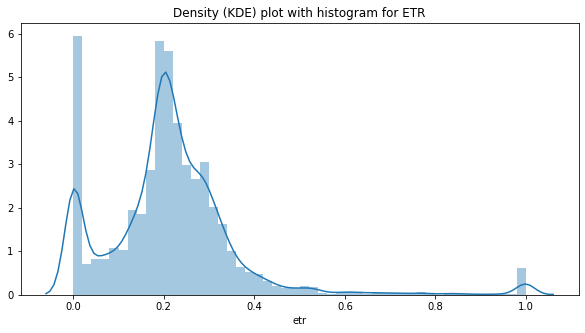

In [183]:
plt.figure(figsize=(10, 5))
sns.distplot(df.etr).set(title="Density (KDE) plot with histogram for ETR")
plt.show()

#### Distribution in each year

As we can see distribution of the ETR is quite constant across the time. We can see that one period before crises (2008) tax avoidance increased and remained stable for several years! Interestingly, in the same period (2008) the number of "honest" companies increased (significantly more companies with the value of 1 ETR).

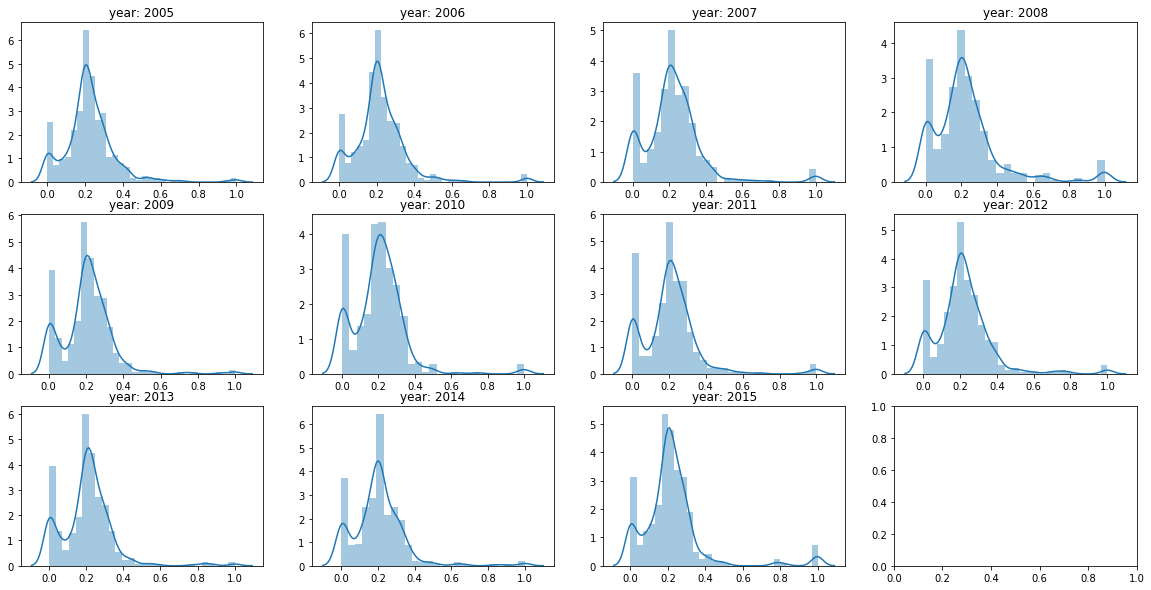

In [180]:
fig, axes = plt.subplots(ncols=4, nrows=3,figsize=(20, 10))
for i, ax in zip(range(2005,2016), axes.flat):
    sns.distplot(df[df.rok == i].etr, ax=ax).set(title = f"year: {i}", xlabel = "")
plt.show()

Quantiles keep more or less the same values. Except during the crisis period as mentioned earlier. Outliers, as mentioned earlier, are particularly numerous in 2008. The visible impact of the business cycle!

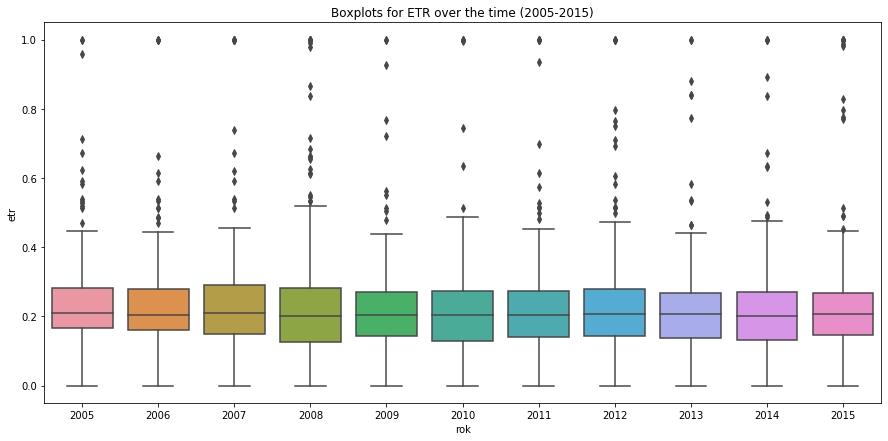

In [200]:
plt.figure(figsize=(15, 7))
sns.boxplot(df.rok, df.etr).set(title = "Boxplots for ETR over the time (2005-2015)")
plt.show()

#### Distribution across countries overtime

1: Warsaw, 2: London, 3: Frankfurt, 4: Paris, 5: Vienna

Based on such plots we can claim that Polish companies like to avoid taxation. The most "honest" group of companies comes from France and London. BUT! This may also be due to the fact that there are differences in the accounting policy between countries, and in addition ETR does not catch situations such as the company has a subsidiary in a tax haven.

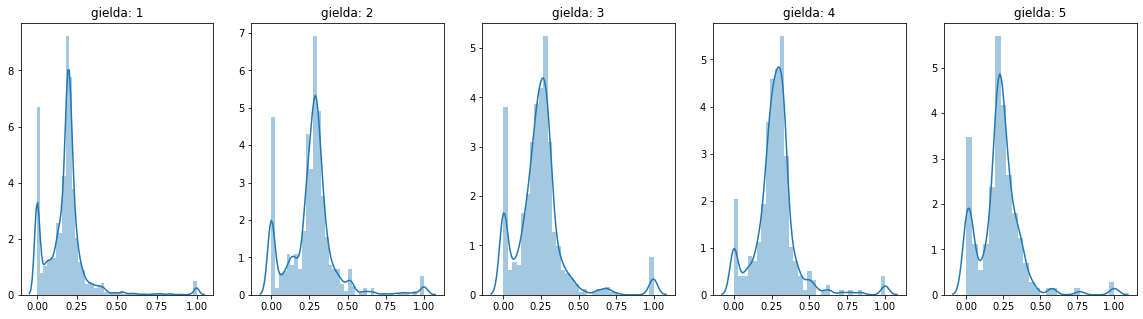

In [191]:
fig, axes = plt.subplots(ncols=5, nrows=1,figsize=(20, 5))
for i, ax in zip(range(1,6), axes.flat):
    sns.distplot(df[df.gielda == i].etr, ax=ax).set(title = f"gielda: {i}", xlabel = "")
plt.show()

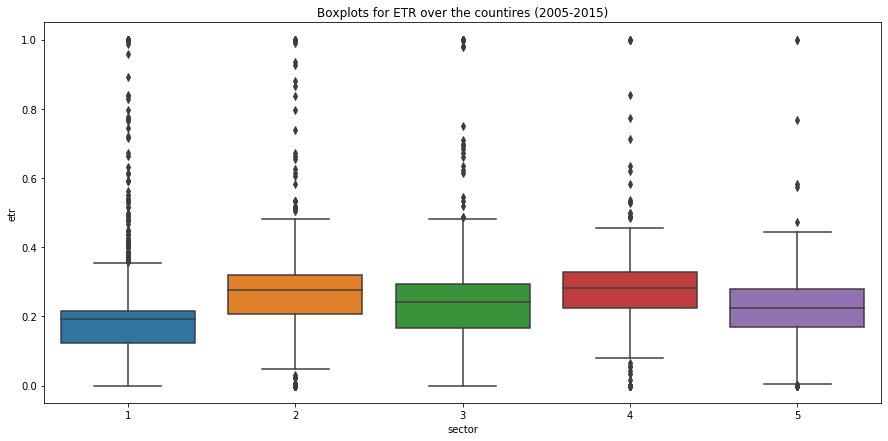

In [235]:
plt.figure(figsize=(15, 7))
sns.boxplot(df.gielda, df.etr).set(title = "Boxplots for ETR over the countires (2005-2015)", xlabel="sector")
plt.show()

#### Distribution across sectors over time

In [194]:
df.sektor.nunique()

10

Here we can see that real estate sector likes tax avoidance very much.  

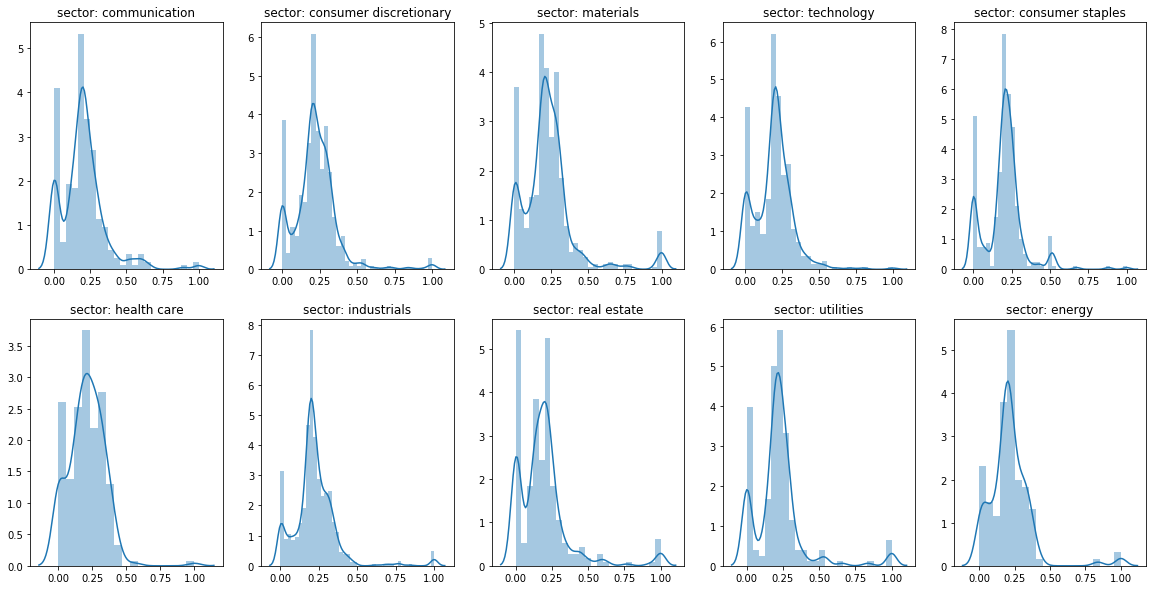

In [201]:
fig, axes = plt.subplots(ncols=5, nrows=2,figsize=(20, 10))
for i, ax in zip(df.sektor.unique(), axes.flat):
    sns.distplot(df[df.sektor == i].etr, ax=ax).set(title = f"sector: {i}", xlabel = "")
plt.show()

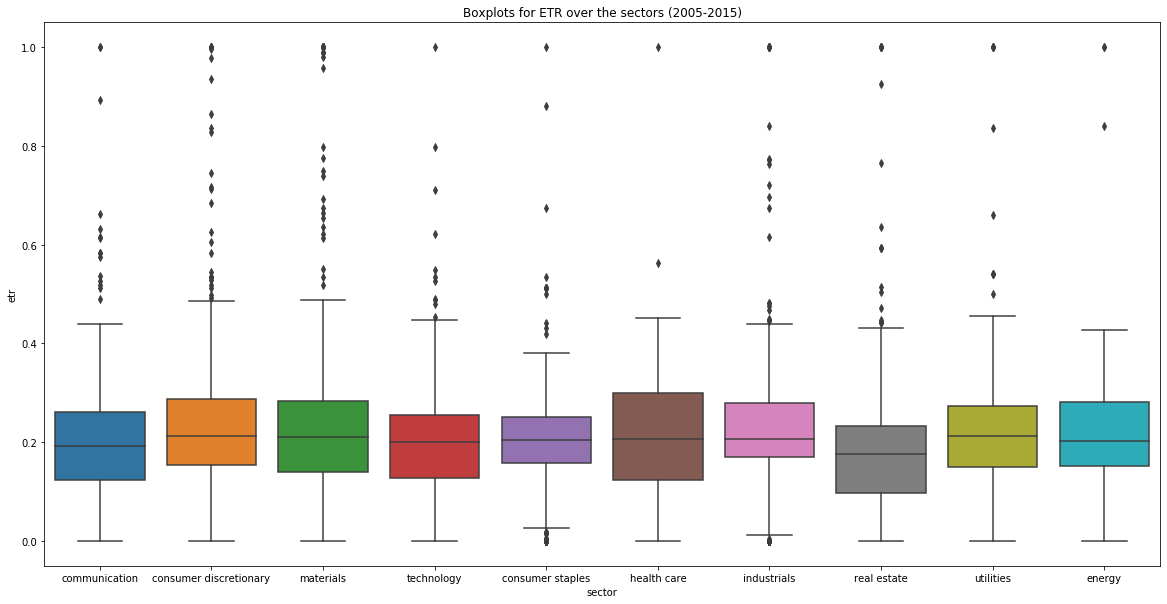

In [236]:
plt.figure(figsize=(20, 10))
sns.boxplot(df.sektor, df.etr).set(title = "Boxplots for ETR over the sectors (2005-2015)", xlabel="sector")
plt.show()

#### Gathered all above analysis into one plot

Ok it is bad idea in such a case (too many levels). But we can clearly confirm some previous conclusions.

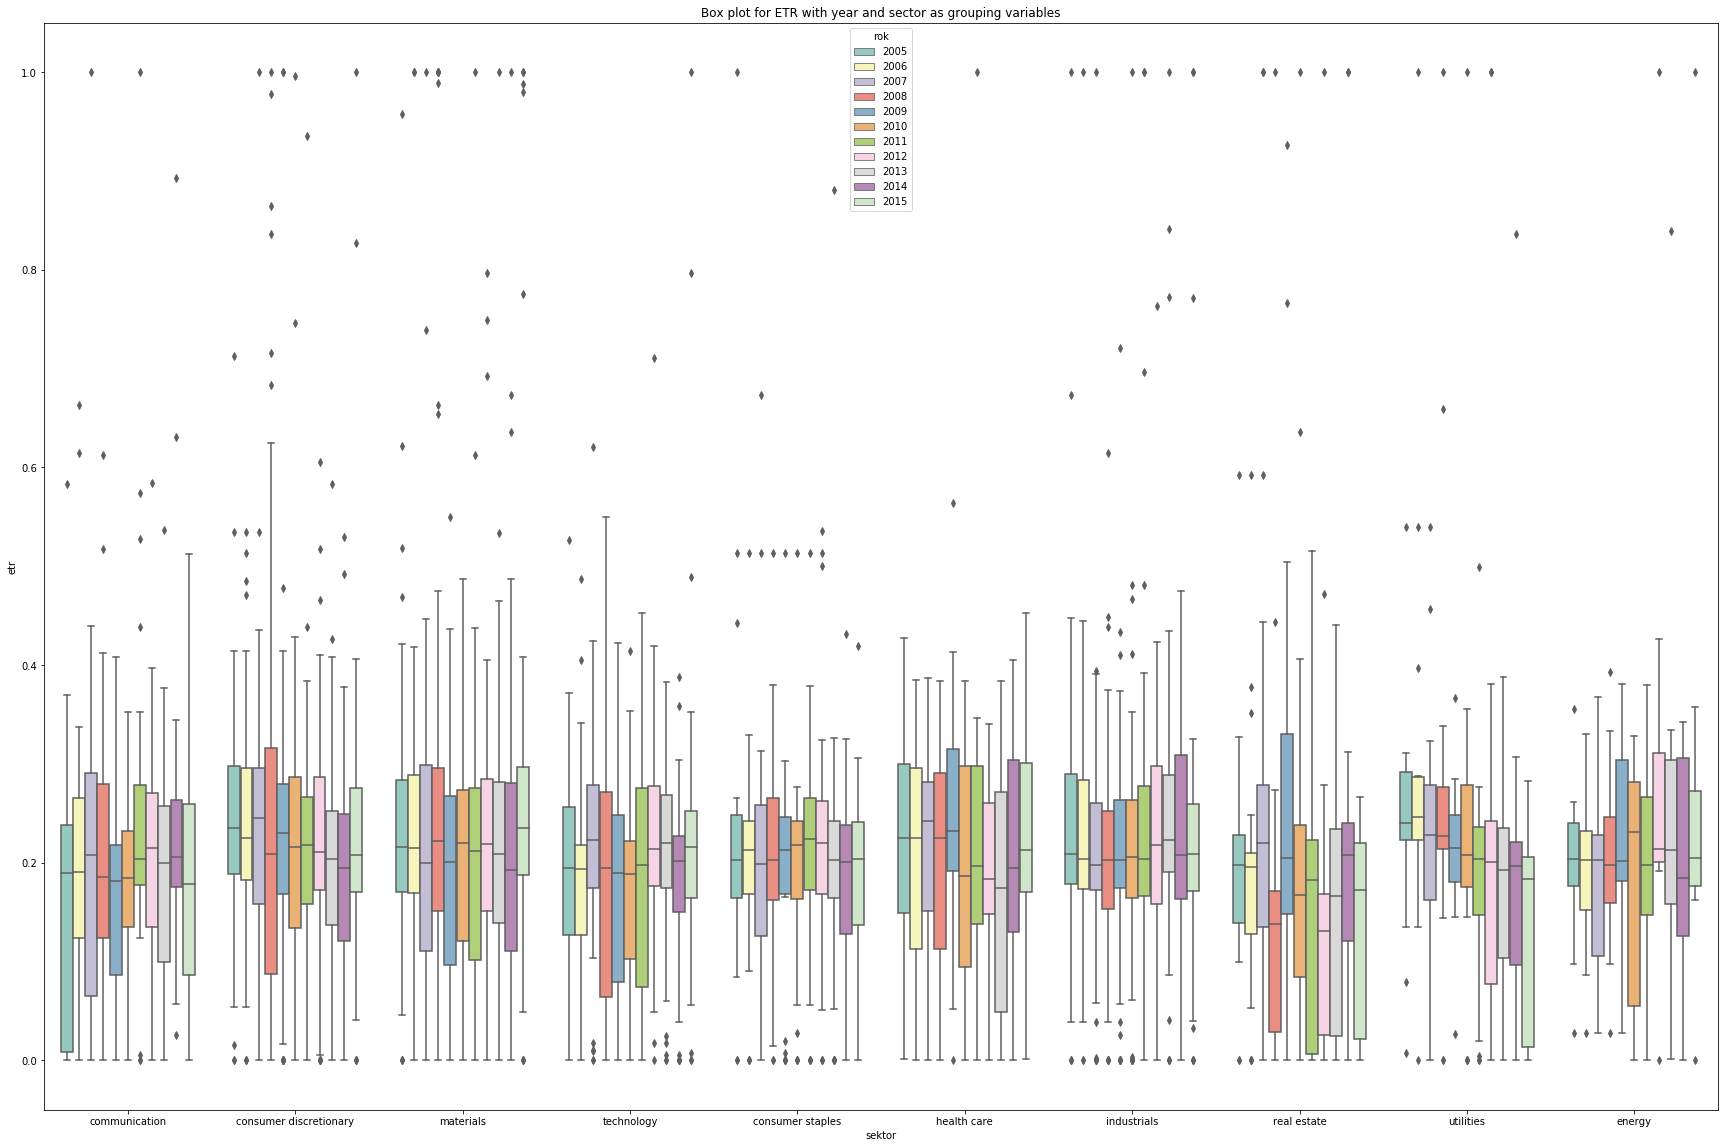

In [269]:
plt.figure(figsize=(30, 20))
sns.boxplot(x="sektor", y="etr", hue="rok", data=df, palette="Set3").set(title="Box plot for ETR with year and sector as grouping variables")
plt.show()

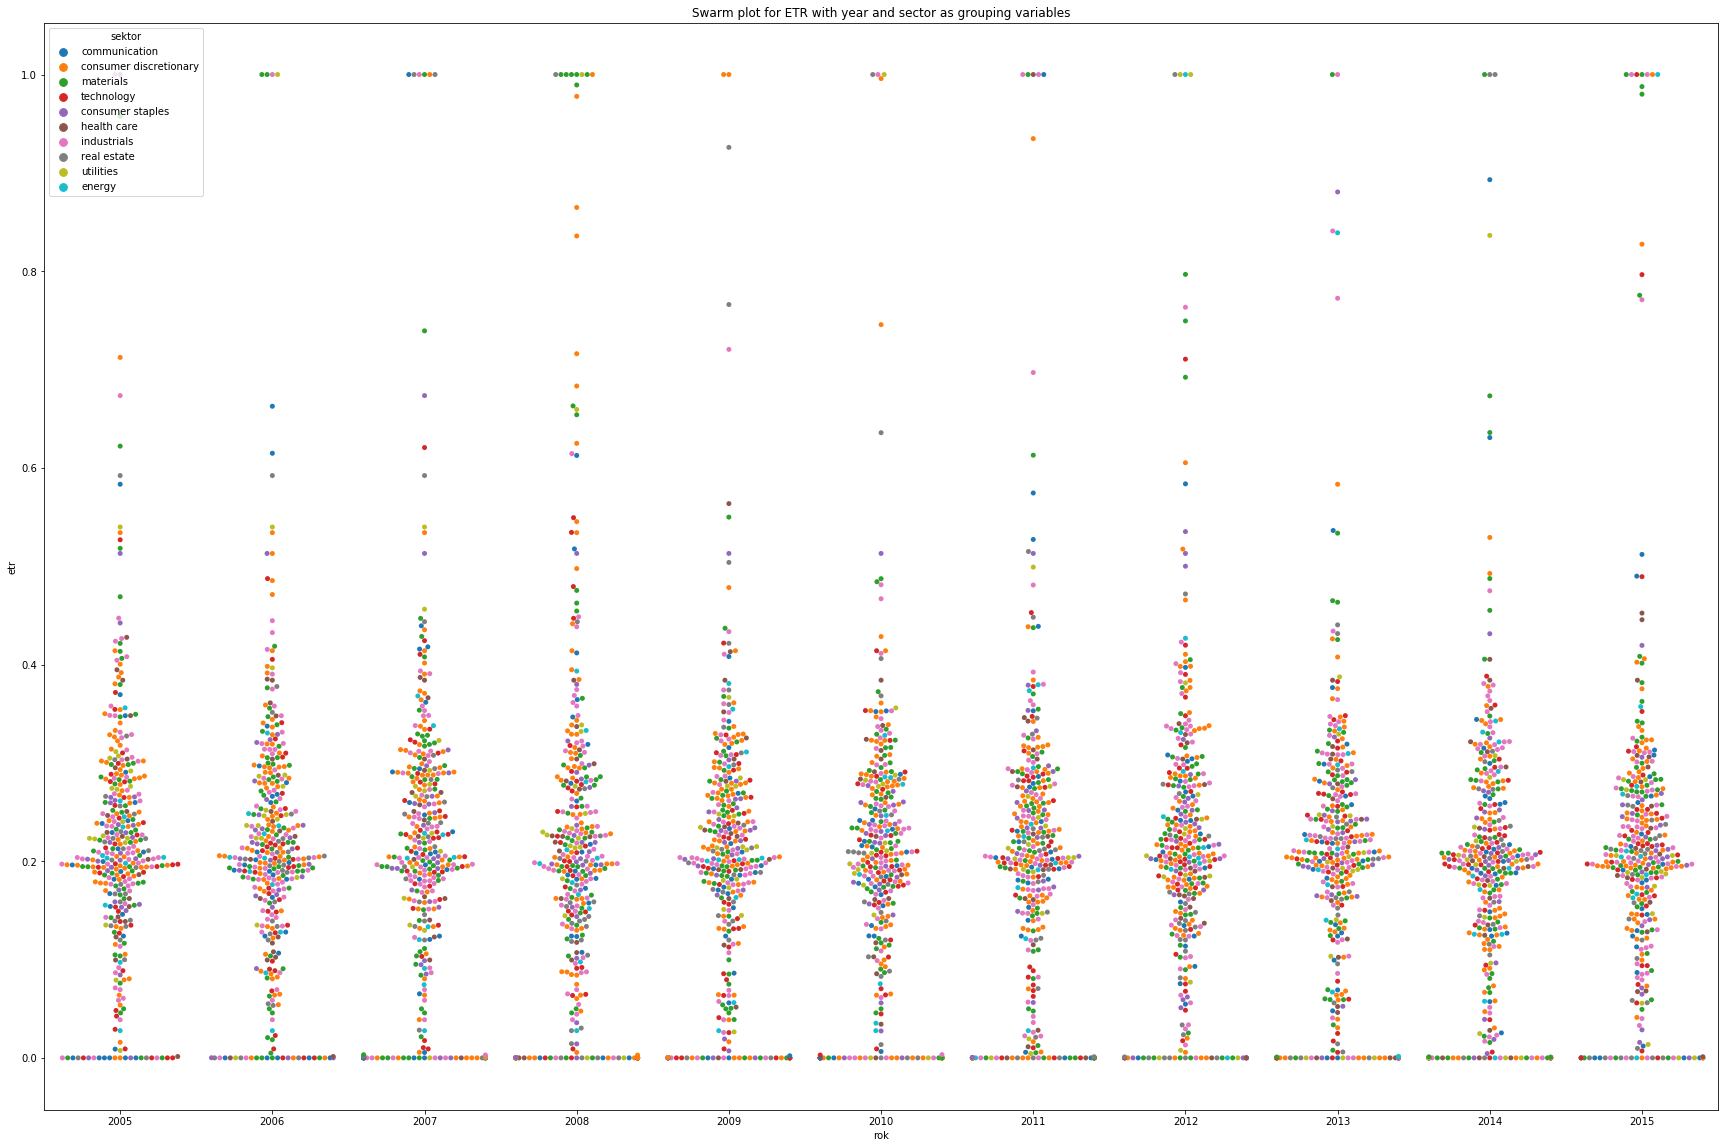

In [271]:
plt.figure(figsize=(30, 20))
sns.swarmplot(x="rok", y="etr", hue="sektor", data=df).set(title="Swarm plot for ETR with year and sector as grouping variables")
plt.show()

#### Two-way (two factor) ANOVA for searching dependencies between ETR, sector and year!

Warning! We don't have balanced data in case of sector!

In [265]:
df.sektor.value_counts()

consumer discretionary    847
industrials               748
materials                 616
technology                407
consumer staples          297
real estate               286
communication             275
health care               209
utilities                 187
energy                    121
Name: sektor, dtype: int64

In [243]:
df_ANOVA = df[["sektor","rok","etr"]].copy()

In [261]:
model = ols('etr ~ C(sektor) + C(rok) + C(sektor):C(rok)', data=df_ANOVA).fit()
anova_model = sm.stats.anova_lm(model, typ=2)
anova_model

,sum_sq,df,F,PR(>F)
C(sektor),0.692161,9.0,3.272159,0.000562
C(rok),0.310472,10.0,1.320966,0.212660
C(sektor):C(rok),2.343792,90.0,1.108017,0.229944
Residual,91.263624,3883.0,NaN,NaN


Based on above output we can conclude that sector has significant impact on ETR, but in case on year and their interaction there is no significant relation!

**Test ANOVA assumptions**

In [262]:
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.8532538414001465 0.0


We don't have normal distribution of the errors! ANOVA might be "damaged"!

**Tukey-multiple pairwise comparison for ETR~sectors**

Based on below summary we can see that significant differences are among: consumer discretionary - technology; industrials - technology; materials - real estate; materials - utilities;

In [264]:
m_comp = pairwise_tukeyhsd(endog=df['etr'], groups=df['sektor'] ,alpha=0.1)
print(m_comp)

                Multiple Comparison of Means - Tukey HSD, FWER=0.10                 
        group1                 group2         meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------
         communication consumer discretionary   0.0208 0.6126 -0.0103   0.052  False
         communication       consumer staples   0.0001    0.9 -0.0374  0.0376  False
         communication                 energy    0.016    0.9 -0.0329  0.0649  False
         communication            health care   0.0066    0.9 -0.0346  0.0477  False
         communication            industrials   0.0212  0.612 -0.0104  0.0528  False
         communication              materials   0.0287 0.2278 -0.0038  0.0613  False
         communication            real estate  -0.0096    0.9 -0.0475  0.0283  False
         communication             technology  -0.0077    0.9 -0.0427  0.0273  False
         communication              utilities   0.0207    0.9 -0.

It seems to be reasonable to split data by sector and model them separately but there is one problem in such approach - some sectors has less observations than 250 and in such a case some ML models works not so well! 